In [1]:
import sys
sys.path.append('../')

import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np
import xarray as xr

from helpers.cm26 import DatasetCM26, read_datasets, discard_land
from helpers.selectors import select_NA, select_Pacific, select_Cem, select_globe, select_Equator, select_ACC, compare, plot
from helpers.operators import Coarsen, Filtering, Subsampling, CoarsenKochkov, CoarsenWeighted

from helpers.ann_tools import ANN, import_ANN, export_ANN
import torch
import torch.optim as optim

import hvplot.xarray
import hvplot
import cmocean
import os
from time import time

%load_ext autoreload
%autoreload 3

# pyqg

In [96]:
from pyqg_generative.tools.operators import advect, divergence, vorticity, gauss_filter
ds = xr.open_dataset('/scratch/pp2681/pyqg_generative/Reference-Default-scaled/eddy/reference_256/0.nc')

In [107]:
import xrft

In [174]:
_ds = ds.isel(time=-1).astype('float64')
nc = 64

u = _ds.u.values
v = _ds.v.values
w = vorticity(u,v)
q = _ds.q.values
psi = _ds.psi.values

uf = gauss_filter(u, nc)
vf = gauss_filter(v, nc)
wf = gauss_filter(w, nc)
qf = gauss_filter(q, nc)
psif = gauss_filter(psi, nc)

dds = xr.Dataset()
dds['SGS_total'] = xr.DataArray(gauss_filter(advect(q,u,v), nc) - advect(qf,uf,vf), dims=['lev','y','x'])
dds['SGS_rel'] = xr.DataArray(gauss_filter(advect(w,u,v), nc) - advect(wf,uf,vf), dims=['lev','y','x'])
dds['psif'] = xr.DataArray(psif, dims=['lev','y','x'])
dds['x'] = ds.x
dds['y'] = ds.y

Etotal = np.real(xrft.isotropic_cross_spectrum(dds['psif'], dds['SGS_total'], dim=('y', 'x')))
print(Etotal.sum().values)
Etotal = Etotal * Etotal['freq_r']
KE = np.real(xrft.isotropic_cross_spectrum(dds['psif'], dds['SGS_rel'], dim=('y', 'x')))
print(KE.sum().values)
KE = KE * KE['freq_r']
PE = Etotal-KE


8.068617029017733e-07
1.5363369834855828e-06


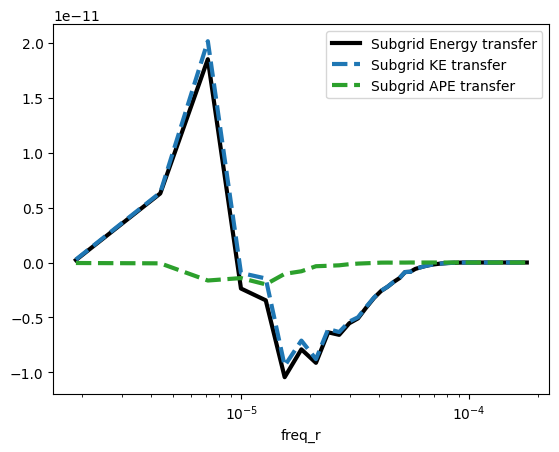

In [175]:
Etotal.sum('lev').plot(color='k', label='Subgrid Energy transfer', lw=3)
KE.sum('lev').plot(label='Subgrid KE transfer', lw=3, ls='--')
PE.sum('lev').plot(label='Subgrid APE transfer', lw=3, ls='--', color='tab:green')
plt.xscale('log')
plt.legend()

# Trained models. offline skill

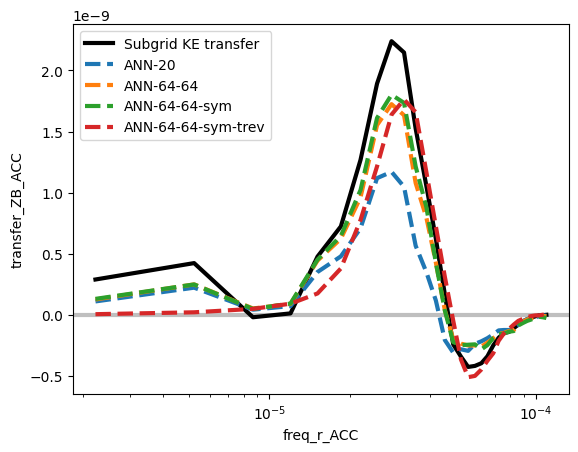

In [138]:
def read(exp='hdn-20', factor=4, dataset='test'):
    return xr.open_dataset(f'/scratch/pp2681/mom6/CM26_ML_models/Gauss-FGR2/{exp}/skill-{dataset}/factor-{factor}.nc')

exp = 'hdn-64-64-sym-trev'
read('hdn-20',6).transfer_ACC.mean('time').plot(label='Subgrid KE transfer',lw=3, color='k')
read('hdn-20',6).transfer_ZB_ACC.mean('time').plot(label='ANN-20',lw=3,ls='--')
read('hdn-64-64',6).transfer_ZB_ACC.mean('time').plot(label='ANN-64-64',lw=3,ls='--')
read('hdn-64-64-sym',6).transfer_ZB_ACC.mean('time').plot(label='ANN-64-64-sym',lw=3,ls='--')
read('hdn-64-64-sym-trev',6).transfer_ZB_ACC.mean('time').plot(label='ANN-64-64-sym-trev',lw=3,ls='--')
#read('hdn-64-64-sym',4).transfer_ZB_Pacific.mean('time').plot(label='ANN',lw=3,ls='--', color='tab:orange')
plt.xscale('log')
plt.legend()
plt.axhline(y=0,color='gray',alpha=0.5,zorder=-1,lw=3)

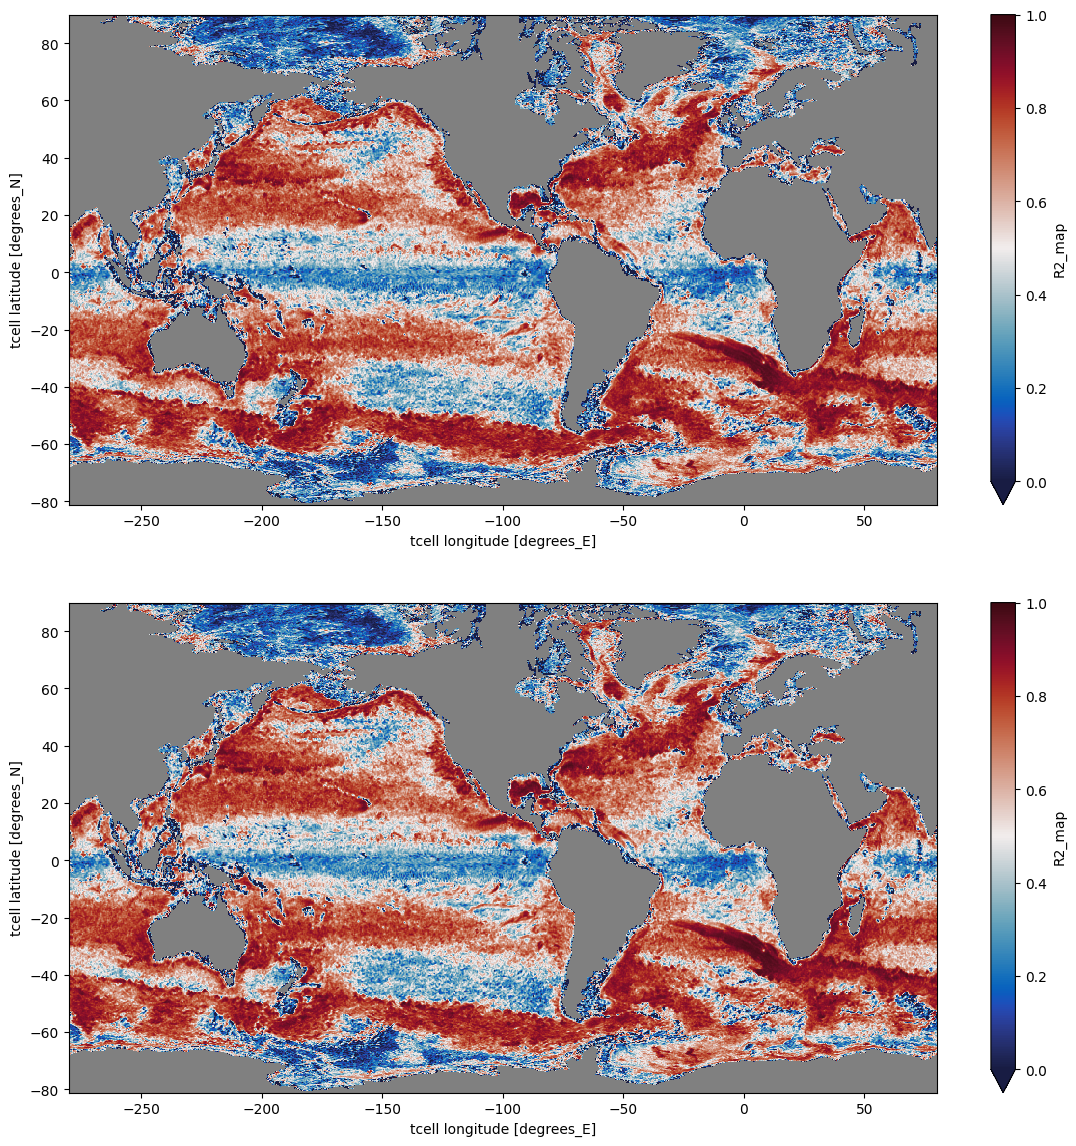

In [86]:
plt.figure(figsize=(14,14))
plt.subplot(2,1,1)
plot(read('hdn-64-64').R2_map, vmax=1, vmin=0, selector=select_globe, cartopy=False)
plt.subplot(2,1,2)
plot(read('hdn-64-64-sym').R2_map, vmax=1, vmin=0, selector=select_globe, cartopy=False)

Correlation: 0.9209755469438984
Relative Error: 0.1349160075187683
R2 =  0.8463950008153915
R2 max =  0.8487852662801743
Optinal scaling: 1.0560413599014282
Nans [test/control]: [14574, 14574]


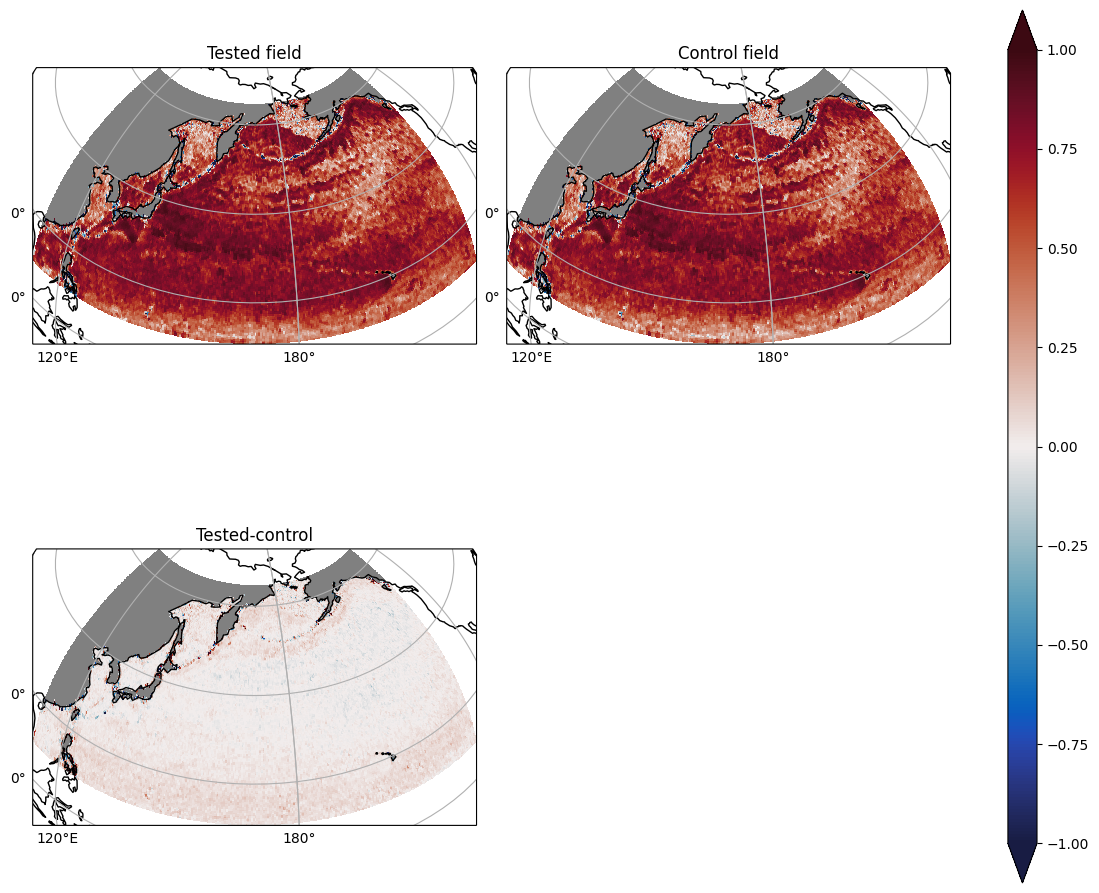

In [84]:
compare(read('hdn-64-64-sym').R2v_map, read('hdn-64-64').R2v_map, vmax=1, vmin=-1, selector=select_Pacific)

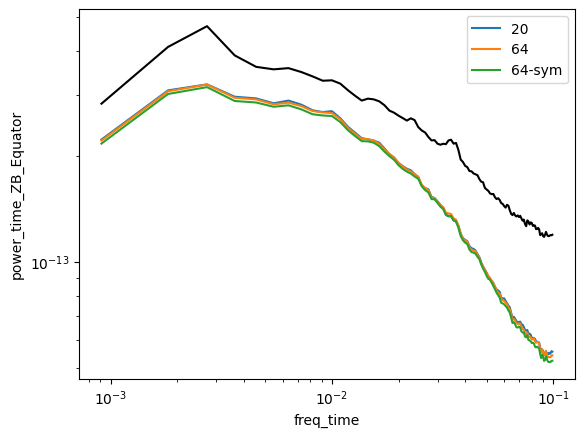

In [119]:
factor = 4
read('hdn-64-64-sym',factor).power_time_Equator.plot(color='k')
read('hdn-20',factor).power_time_ZB_Equator.plot(label='20')
read('hdn-64-64',factor).power_time_ZB_Equator.plot(label='64')
read('hdn-64-64-sym',factor).power_time_ZB_Equator.plot(label='64-sym')
#read('hdn-64-64-sym-trev',factor).power_time_ZB_Equator.plot(label='64-sym')
plt.xscale('log')
plt.yscale('log')
plt.legend()

In [134]:
print(read('hdn-64-64-sym',12,'test').R2.values, read('hdn-64-64-sym',12,'train').R2.values)

0.6065942645072937 0.6030495166778564


In [135]:
print(read('hdn-64-64',12,'test').R2.values, read('hdn-64-64',12,'train').R2.values)

0.606426864862442 0.6042053401470184
